# Astro 528: High-performance Computing for Astrophysics
## Lab 8, Exercise 2
## GPU Programming:  Writing Custom Kernels

### Why a Jupyter notebook?
This exercise is again a Jupyter notebook, rather than Pluto.  Why?  When using the GPU, it is possible to do things that require restarting Julia in order to recover from.  That requires shutting down the Pluto server.  The way that our Pluto servier is run from JupyterLab, that would require killing your whole JupyterLab session and requesting a new one.  This exercise has some custom CUDA kernels.  When I tested it, the notebook worked correctly.  But I encourage students to try tweaking things, and that could easily lead to some errors that require a restart.  So I decided to put this into a Jupyter notebook.  In Jupyter, you can go to the *Kernel* menu and select *Restart Kernel* to get a new kernel and try again.

### Setting up the GPU
Remember that when using Jupyter, the order in which you execute cells affects the state of the notebook.  (In contrast to in Pluto, where it figures out the order that cells are to be run, so we can put implementation details at the bottom of the notebook, where they're less distracting.)
Therefore, we place code in the order that it should be run.  We'll start loading the packages we'll use for writing our custom GPU kernels.

In [1]:
using KernelAbstractions   # Allows writing code once for different brand GPUs
using CUDA, CUDAKernels    # for NVIDIA GPUs
using BenchmarkTools       # for timing
using Markdown

As before we will check that the system we're running on has an NVIDIA GPU that we can use and check what's installed.

In [2]:
CUDA.devices()

CUDA.DeviceIterator() for 1 devices:
0. Tesla P100-PCIE-12GB

In [3]:
CUDA.versioninfo()

CUDA toolkit 11.4, artifact installation
NVIDIA driver 440.64.0, for CUDA 10.2
CUDA driver 11.4

Libraries: 
- CUBLAS: 11.5.4
- CURAND: 10.2.5
- CUFFT: 10.5.1
- CUSOLVER: 11.2.0
- CUSPARSE: 11.6.0
- CUPTI: 14.0.0
- NVML: 10.0.0+440.64.0
- CUDNN: 8.20.2 (for CUDA 11.4.0)
- CUTENSOR: 1.3.0 (for CUDA 11.2.0)

Toolchain:
- Julia: 1.6.0
- LLVM: 11.0.1
- PTX ISA support: 3.2, 4.0, 4.1, 4.2, 4.3, 5.0, 6.0, 6.1, 6.3, 6.4, 6.5, 7.0
- Device capability support: sm_35, sm_37, sm_50, sm_52, sm_53, sm_60, sm_61, sm_62, sm_70, sm_72, sm_75, sm_80

1 device:
  0: Tesla P100-PCIE-12GB (sm_60, 11.902 GiB / 11.912 GiB available)


We'll make use of the GPU's warpsize later in the exericse, so let's get it now.

In [4]:
warpsize(CUDA.device())

32

## CPU version of code to run in parallel 
We'll write two functions that we'll convert into GPU kernels.  The first, `calc_rv_circ`, will be a simple function, so we keep things simple.  The second, `calc_rv_kepler`, will call other several user-written functions.  We'll even place the code to solve Kepler's equation in a module to help with code maintainability.

In [5]:
function calc_rv_circ(t::Real; param::NamedTuple )
    P = param.P
    K = param.K
    M0 = param.M0
    mean_anom = t*2π/P-M0
    rv = K*sin(mean_anom)
end

calc_rv_circ (generic function with 1 method)

### Code for computing radial velocity of a Keplerian orbit

In [6]:
"Solve Computing Eccentric Anomaly from Mean Anomally via Kepler's Equation"
module KeplerEqn
using KernelAbstractions  # since we'll use KernelAbstractions to get slightly better performance.
export calc_ecc_anom

"""   ecc_anom_init_guess_danby(M, ecc)
Initial guess for eccentric anomaly given mean anomaly (M) and eccentricity (ecc)
    Based on "The Solution of Kepler's Equations - Part Three"  
    Danby, J. M. A. (1987) Journal: Celestial Mechanics, Volume 40, Issue 3-4, pp. 303-312  1987C
eMec..40..303D
"""
function ecc_anom_init_guess_danby(M, ecc)
    k = convert(typeof(ecc),0.85)
    if(M<zero(M)) M += 2pi end
    (M<pi) ? M + k*ecc : M - k*ecc;
end

"""   update_ecc_anom_laguerre(E, M, ecc)
Update the current guess (E) for the solution to Kepler's equation given mean anomaly (M) and ecc
entricity (ecc)
   Based on "An Improved Algorithm due to Laguerre for the Solution of Kepler's Equation"
   Conway, B. A.  (1986) Celestial Mechanics, Volume 39, Issue 2, pp.199-211  1986CeMec..39..199C
"""
function update_ecc_anom_laguerre(E, M, ecc)
  es, ec = ecc.*sincos(E)
  F = (E-es)-M
  Fp = one(E)-ec
  Fpp = es
  n = 5
  root = sqrt(abs((n-1)*((n-1)*Fp*Fp-n*F*Fpp)))
  denom = Fp>zero(E) ? Fp+root : Fp-root
  return E-n*F/denom
end

const default_ecc_anom_tol = 1e-8
"Loop to update the current estimate of the solution to Kepler's equation."
function calc_ecc_anom(mean_anom, ecc, tol = default_ecc_anom_tol )
    default_max_its_laguerre = 200
    max_its = default_max_its_laguerre
    @assert zero(ecc) <= ecc < one(ecc)
    @assert tol*100 <= one(tol)
    #M = mod(mean_anom,convert(typeof(mean_anom),2pi))
    M = rem2pi(mean_anom,RoundNearest)
    E = ecc_anom_init_guess_danby(M,ecc)
    # Slight optimization from our original CPU code here, to tell the GPU to try to unroll the first several itterations of the for loop. 
    #for i in 1:max_its
    KernelAbstractions.Extras.@unroll 6 for i in 1:max_its
       E_old = E
       E = update_ecc_anom_laguerre(E_old, M, ecc)
       if abs(E-E_old)<convert(typeof(mean_anom),tol) break end
    end
    return E
end

end # module KeplerEqn

Main.KeplerEqn

In [7]:
function calc_true_anom(ecc_anom::Real, e::Real)
    true_anom = 2*atan(sqrt((1+e)/(1-e))*tan(ecc_anom/2))
end

calc_true_anom (generic function with 1 method)

In [8]:
function calc_rv_kepler(t::Real; param::NamedTuple )
    P = param.P
    K = param.K
    ecc = param.e
    ω = param.ω
    M0 = param.M0
    mean_anom = t*2π/P-M0
    ecc_anom = KeplerEqn.calc_ecc_anom(mean_anom,ecc)
    true_anom = calc_true_anom(ecc_anom,ecc)
    rv = (cos(ω+true_anom)+ecc*cos(ω)) * K/sqrt((1-ecc)*(1+ecc))
end

calc_rv_kepler (generic function with 1 method)

## Writing GPU kernels with KernelAbstractions.jl
The CPU version of `calc_rv_circ_kernel` and `calc_rv_kepler_kernel` operate on scalars.  For GPU calculations to be efficient, we need them to operate on arrays.  For some simple use cases (like the examples below), we could just use `map`.  However, it is useful to start simple when demonstrating how to write a custom GPU kernel.  Below we'll using the `KernelAbstractions` `@kernel` macro to simplify writing our GPU kernel.  For example, rather than calculating the index to operate on explicitly from the thread and block indices, we'll use the `@index` macro to get the index for each thread to operate on.  There's also a useful `@Const` macro that allows us to specify that the data in our input arrays will remain constant, allowing for memory-related optimizations that aren't always possible. It will be up to us when we call the kernel to make sure that there as many threads as elements of `y` and `times`.  

In [9]:
KernelAbstractions.@kernel function calc_rv_circ_kernel(y, @Const(times), @Const(param) )
    I = @index(Global)
    t = times[I]
    y[I] = calc_rv_circ(t, param=param)
end

calc_rv_circ_kernel (generic function with 5 methods)

In [10]:
KernelAbstractions.@kernel function calc_rv_kepler_kernel(y, @Const(times), @Const(param) )
    I = @index(Global)
    t = times[I]
    y[I] = calc_rv_kepler(t,param=param)
end

calc_rv_kepler_kernel (generic function with 5 methods)

One great feature of the `KernelAbstractions.jl` package is that we can the core code for kernels once, and turn them into kernels that can run on a CPU, an NVIDIA GPU or an AMD GPU. 
In order to get a kernel that can be executed, we call the function returned by the `@kernel` macro, specifying the hardware we will use to execute the kernel.  
Optionally, we can specify the *workgroup size* and the size of the global indices to be used, when we request the kernel.  If we don't provide that info now, then we'll need to provide it at runtime. As we discussed previously, its often useful for the compiler to have information at compile time.  Therefore, we'll specify the workgroup size at compile time in building our kernels below.  We'll leave the size of the global indices as a dynamic parameter, so that we don't need to recompile a kernel for each problem size.

In [11]:
cpu_kernel_calc_rv_circ! = calc_rv_circ_kernel(CPU(), 16)

KernelAbstractions.Kernel{CPU, KernelAbstractions.NDIteration.StaticSize{(16,)}, KernelAbstractions.NDIteration.DynamicSize, typeof(cpu_calc_rv_circ_kernel)}(cpu_calc_rv_circ_kernel)

In [12]:
cpu_kernel_calc_rv_kepler! = calc_rv_kepler_kernel(CPU(), 16)

KernelAbstractions.Kernel{CPU, KernelAbstractions.NDIteration.StaticSize{(16,)}, KernelAbstractions.NDIteration.DynamicSize, typeof(cpu_calc_rv_kepler_kernel)}(cpu_calc_rv_kepler_kernel)

## Generate data for testing kernels
Let's generate some simulated data for testing our CPU kernels.  Below are functions that will make it easy to generate datasets of various sizes later in the exercise.

In [13]:
function generate_obs_data(times::AbstractArray; param, σ_obs, model)
    num_obs = length(times)
    rv_true = model.(times, param = param)
    rv_obs = rv_true .+ σ_obs.*randn(num_obs)
    obs_data = (; t=times, rv=rv_obs, σ=σ_obs.*ones(num_obs) )
end

function generate_obs_data(;time_span, num_obs, param, σ_obs, model)
    days_in_year = 365.2425
    times = sort(time_span*days_in_year*rand(num_obs))
    generate_obs_data(times, param=param, σ_obs=σ_obs, model=model)
end

generate_obs_data (generic function with 2 methods)

In [14]:
begin
    P_true = 3.0
    K_true = 5.0
    e_true = 0.4
    ω_true = π/4
    M0_true = π/4
    θ_true  = (;P=P_true, K=K_true, e=e_true, ω=ω_true, M0=M0_true )
end

(P = 3.0, K = 5.0, e = 0.4, ω = 0.7853981633974483, M0 = 0.7853981633974483)

In [15]:
n_obs = 1_000_000
time_span_in_years = 1
obs_data = generate_obs_data(time_span=time_span_in_years, num_obs=n_obs, param=θ_true, σ_obs=1.0, model=calc_rv_kepler);

It's often nice to visualize our data, just to make sure our code is doing what we expect.  I've commented out the plotting code, so the pbs script will work.  Also, note that if we plotted all the data, it would take a *very* long time, you'll be better off just ploting a random sample of the points.

In [ ]:
#using Plots

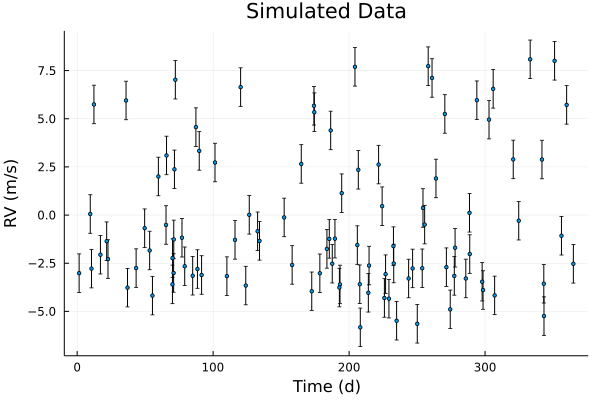

In [16]:
#=
idx_plt = length(obs_data.t) <= 100 ? (1:length(obs_data.t))  : rand(1:length(obs_data.t),100) 
plt = scatter(obs_data.t[idx_plt],obs_data.rv[idx_plt],yerr=obs_data.σ[idx_plt],legend=:none,ms=2)
xlabel!(plt,"Time (d)")
ylabel!(plt,"RV (m/s)")
title!(plt,"Simulated Data")
=#

## Executing a kernel
First, we'll make sure that the CPU kernel we generated with KernelAbstractions gives similar results.  Since our kernel needs an array to write it's output to, we'll allocate memory for that.  Then we'll pass the optional arguement `ndrange` to tell it the size of the global indices that it should use for the times and outputs.  Kernel calls can be asynchronous, so they return an *event* that can be used to check whether the kernel has completed.  We call `wait` on the event to make sure our kernel has completed its work before using the results.

In [17]:
output_cpu = similar(obs_data.t)
cpu_event = cpu_kernel_calc_rv_circ!(output_cpu, obs_data.t, θ_true, ndrange=size(obs_data.t))
wait(cpu_event)

Now we'll try performing the same calculation on the GPU.  We generate a GPU kernel for NVIDIA GPUs by passing `CUDADevice()` instead of `CPU()`.  We'll specify a workgroup size equal to the warpsize on our GPUs.  

In [18]:
output_gpu_d = CUDA.zeros(length(obs_data.t));
obs_times_d = cu(obs_data.t);

In [19]:
gpu_kernel_calc_rv_circ! = calc_rv_circ_kernel(CUDADevice(), 32)

KernelAbstractions.Kernel{CUDADevice, KernelAbstractions.NDIteration.StaticSize{(32,)}, KernelAbstractions.NDIteration.DynamicSize, typeof(gpu_calc_rv_circ_kernel)}(gpu_calc_rv_circ_kernel)

In [21]:
gpu_event = gpu_kernel_calc_rv_circ!(output_gpu_d, obs_times_d, θ_true, ndrange=size(obs_times_d))
wait(gpu_event)

## Accuracy of GPU calculations
Before we start benchmarking, let's check the the results from the GPU kernel are accurate.    

In [22]:
maximum(abs.(collect(output_gpu_d).-output_cpu))

0.00015977717873867647

That's likely larger than we'd normally expect.  What could have caused it.  It's good to check the types of the arrays on the device.

In [23]:
typeof(obs_times_d), typeof(output_gpu_d)

(CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer})

Why?  Look back at where we allocated `obs_times_d` and `output_gpu_d`.  `cu` defaults to sending arrays as Float32's rather than Float64's.  We can be explicit about what type we want.  Additionally, the default element type for `CUDA.zeros` is Float32, rather than Float64 (like it is for `Base.zeros`).  

In [24]:
obs_times_d = convert(CuArray{Float64,1},obs_data.t);
output_gpu_d64 = CUDA.zeros(Float64,length(obs_data.t));
gpu_event = gpu_kernel_calc_rv_circ!(output_gpu_d64, obs_times_d, θ_true, ndrange=size(obs_times_d))
wait(gpu_event)
maximum(abs.(collect(output_gpu_d64).-output_cpu))

8.881784197001252e-16

That should be much better.  (It's still not zero, since the GPU defaults to allowing the optimizer to perform optimizations that are not IEEE-compliant.) 

## Comparing CPU & GPU Performance 
Next, we'll comapre the time to execute the CPU and GPU kernels.  In the test below, we'll compute the predicted radial velcoity for the first `num_obs_to_eval` time.  The default code below is for the full set of observation times.  But you may wish to try comparing the performance for fewer observations (without having to regenerate the simulated data).

In [25]:
num_obs_to_eval = length(obs_data.t)

1000000

In [100]:
@benchmark  wait(cpu_kernel_calc_rv_circ!($output_cpu, $obs_data.t, $θ_true, ndrange=$num_obs_to_eval )) seconds=1

BenchmarkTools.Trial: 233 samples with 1 evaluation.
 Range (min … max):  4.251 ms …   8.529 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.264 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.312 ms ± 356.056 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     █▁                                                        
  ▄▇███▃▃▅▃▃▃▃▁▂▃▅▆▆▃▃▃▃▃▁▃▃▁▃▃▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▃ ▃
  4.25 ms         Histogram: frequency by time        4.42 ms <

 Memory estimate: 3.98 KiB, allocs estimate: 67.

In [101]:
@benchmark wait(gpu_kernel_calc_rv_circ!($output_gpu_d64, $obs_times_d, $θ_true, ndrange=$num_obs_to_eval)) seconds=1

BenchmarkTools.Trial: 6200 samples with 1 evaluation.
 Range (min … max):  147.691 μs … 602.741 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     150.866 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   155.341 μs ±  26.441 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▅█▇▄▃▃▄▃▁              ▁                                     ▁
  ███████████▇▇▆▆▇▇█▇▇███████▆▅▄▅▅▇▅▅▆▇▅▅▅▅▃▅▃▃▁▄▃▃▃▃▁▃▃▁▅▁▃▅▇▇ █
  148 μs        Histogram: log(frequency) by time        213 μs <

 Memory estimate: 3.77 KiB, allocs estimate: 77.

2a.  How much faster was performing the computations on the GPU than on the CPU? 

In [28]:
response_2a = missing # md"Insert response"

missing

## Performance as a function of workgroup size
When we generate a kernel to run on the GPU, the workgroup size can make a significant difference in the performance.  My understanding is that the workgroup size is equivalent to the block size on NVIDIA GPUs.  response_2a = missing # md"Insert response"

2b.  What do you predict for the compute time for the same GPU kernel, except with the workgroup size set to 1?

In [29]:
response_2b = missing # md"Insert response"

missing

In [30]:
gpu_kernel_calc_rv_circ_alt! = calc_rv_circ_kernel(CUDADevice(), 1)

KernelAbstractions.Kernel{CUDADevice, KernelAbstractions.NDIteration.StaticSize{(1,)}, KernelAbstractions.NDIteration.DynamicSize, typeof(gpu_calc_rv_circ_kernel)}(gpu_calc_rv_circ_kernel)

In [102]:
@benchmark wait(gpu_kernel_calc_rv_circ_alt!($output_gpu_d, $obs_times_d, $θ_true, ndrange=$num_obs_to_eval)) seconds=1

BenchmarkTools.Trial: 351 samples with 1 evaluation.
 Range (min … max):  2.746 ms …  3.007 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.840 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.835 ms ± 49.677 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▇█                          ▇                       
  ▂▃▂▁▁▂▄▂███▅▃▃▃▃▆▅▃▄▄▃▅▅▅▃▄▃▅▃▅▅▃▅▄███▆▄▄▆▂▂▂▃▁▃▂▃▅▄▃▃▄▃▁▄ ▃
  2.75 ms        Histogram: frequency by time        2.94 ms <

 Memory estimate: 3.77 KiB, allocs estimate: 77.

2c.  How did the performance with a workgrop size of 1 compare to your predictions?  

In [32]:
response_2c = missing # md"Insert response"

missing

If you're likely to be using a GPU for parallelizing your project code, then try adjusting the workgroup size to other values (between 1 and twice the warpsize) and see how it affects the performance.

## Comparing performance of kernels
So far, we've been benchmarking a relatively simple kernel (some arithmetic and one trig function).  Now, we'll try switching to computing the radial velocity assuming a Keplerian orbit.  First, we'll use a CPU version of the kernel.  

In [103]:
@benchmark wait(cpu_kernel_calc_rv_kepler!($output_cpu, $obs_data.t, $θ_true, ndrange=size($obs_data.t))) seconds=1

BenchmarkTools.Trial: 15 samples with 1 evaluation.
 Range (min … max):  66.724 ms …  69.143 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     67.157 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   67.304 ms ± 627.755 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃   ▃     ▃    █                                              
  █▁▁▇█▁▁▁▇▁█▇▁▁▁█▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  66.7 ms         Histogram: frequency by time         69.1 ms <

 Memory estimate: 3.97 KiB, allocs estimate: 66.

Next, we'll create a GPU kernel to benchmark the Keplerian calculation on the GPU.

In [34]:
gpu_kernel_calc_rv_kepler! = calc_rv_kepler_kernel(CUDAKernels.CUDADevice(), 32)

KernelAbstractions.Kernel{CUDADevice, KernelAbstractions.NDIteration.StaticSize{(32,)}, KernelAbstractions.NDIteration.DynamicSize, typeof(gpu_calc_rv_kepler_kernel)}(gpu_calc_rv_kepler_kernel)

2d.   Before you run the benchmarks, what do you expect for the GPU performance if we use a workgroup size equal to the warpsize?  What if we use a workgroup size of 1?  Explain your reasoning.  response_2c = missing # md"Insert response"

In [35]:
response_2d = missing # md"Insert response"

missing

In [104]:
@benchmark wait(gpu_kernel_calc_rv_kepler!($output_gpu_d, $obs_times_d, $θ_true, ndrange=size($obs_times_d))) seconds=1

BenchmarkTools.Trial: 1522 samples with 1 evaluation.
 Range (min … max):  549.781 μs … 837.586 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     632.604 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   642.696 μs ±  44.663 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                ▅      █▇▁                                       
  ▂▂▂▁▁▂▃▅▃▄▅▄▄▃█▇▅▆▇▆▅███▇▆▆▄▅▄▅▅▆▇▅▅█▇▃▅▄▄▄▆█▅▃▅▃▃▂▃▂▂▂▁▁▃▄▂▁ ▃
  550 μs           Histogram: frequency by time          750 μs <

 Memory estimate: 3.77 KiB, allocs estimate: 77.

In [105]:
gpu_kernel_calc_rv_kepler_alt! = calc_rv_kepler_kernel(CUDAKernels.CUDADevice(), 1)
@benchmark wait(gpu_kernel_calc_rv_kepler_alt!($output_gpu_d, $obs_times_d, $θ_true, ndrange=size($obs_times_d))) seconds=1

BenchmarkTools.Trial: 88 samples with 1 evaluation.
 Range (min … max):  11.273 ms … 11.478 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.349 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.368 ms ± 42.101 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                    ▂ █ ▃▇                                     
  ▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▇█▇█▇██▅▅▃█▃▃▁▅▃▃▁▁▁▃▁▁▁▃▁▃▃▅▆▆▅▆▃▁▁▅▁▁▃▃▃ ▁
  11.3 ms         Histogram: frequency by time        11.5 ms <

 Memory estimate: 3.77 KiB, allocs estimate: 77.

2e.  How did the benchmarking results for the GPU version compare to your expectations?  What could explain the differences? 

In [38]:
response_2e = missing # md"Insert response"

missing

## Improving performance by performing reductions on GPU
In the previous calculations, there was a substantial ammount of data to be transfered back from the GPU to CPU.  Often, we don't need all the data to be moved back to the CPU, since we're primarily interested in one or more summary statistics.  For example, we might be interested in the chi-squared statistic for comparing our model predictions to the data.  In that case, we'll only need to return a very small ammount of data from the GPU back to the CPU.  Below, we'll see how that affects the performance.  

First, let's try calculating chi-squared the obvious way on the CPU.

In [39]:
function calc_chisq_rv_circ_cpu_simple(data, param)
    @assert length(data.t) == length(data.rv) == length(data.σ) 
    sum(((calc_rv_circ.(data.t, param=param).-data.rv)./data.σ).^2)
end

calc_chisq_rv_circ_cpu_simple (generic function with 1 method)

In [40]:
function calc_chisq_rv_kepler_cpu_simple(data, param)
    @assert length(data.t) == length(data.rv) == length(data.σ) 
    sum(((calc_rv_kepler.(data.t, param=param).-data.rv)./data.σ).^2)
end

calc_chisq_rv_kepler_cpu_simple (generic function with 1 method)

In [41]:
chisq_from_cpu_simple = calc_chisq_rv_kepler_cpu_simple(obs_data, θ_true)

1.0003088895690591e6

In [106]:
@benchmark calc_chisq_rv_kepler_cpu_simple($obs_data, $θ_true) seconds=1

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  246.685 ms … 250.392 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     248.321 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   248.228 ms ±   1.545 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ █                       █         █                       █  
  █▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  247 ms           Histogram: frequency by time          250 ms <

 Memory estimate: 7.63 MiB, allocs estimate: 2.

In [43]:
function cpu_calc_chisq_kepler(t::AbstractArray, rv_obs::AbstractArray, σ::AbstractArray, θ; workspace = missing )
    @assert length(t) == length(rv_obs) == length(σ)
    @assert ismissing(workspace) || length(t) == length(workspace)
    rv_pred = ismissing(workspace) ? similar(rv_obs) : workspace
    wait(cpu_kernel_calc_rv_kepler!(rv_pred, t, θ, ndrange=size(t)))
    χ² = sum(((rv_pred.-rv_obs)./σ).^2)
end

function cpu_calc_chisq_kepler(data::NamedTuple, θ; workspace = missing)
    cpu_calc_chisq_kepler(data.t, data.rv, data.σ, θ, workspace = workspace)
end

cpu_calc_chisq_kepler (generic function with 2 methods)

In [44]:
cpu_calc_chisq_kepler(obs_data, θ_true) ≈ calc_chisq_rv_kepler_cpu_simple(obs_data, θ_true)

true

Now let's try the same calculation on the CPU using the CPU kernel built by `KernelAbstractions`.

In [107]:
@benchmark cpu_calc_chisq_kepler($obs_data,$θ_true) seconds=1

BenchmarkTools.Trial: 15 samples with 1 evaluation.
 Range (min … max):  69.499 ms … 76.525 ms  ┊ GC (min … max): 0.00% … 5.18%
 Time  (median):     69.639 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   70.992 ms ±  2.154 ms  ┊ GC (mean ± σ):  0.74% ± 1.84%

  █                                                            
  █▄▁▁▁▄▁▁▁▄▁▁▁▁▁▁▁▁▄▁▁▁▁▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  69.5 ms         Histogram: frequency by time        76.5 ms <

 Memory estimate: 15.26 MiB, allocs estimate: 70.

That was likely much faster than the simple way!  How is that possible?  The `KernelAbstractions` package is also parallelizing the calculation over multiple threads (assuming that you launched julia using multipel threads).   Let's check how many threads are avaliable.

In [46]:
Threads.nthreads()

4

Since KernelAbstractions is primarily geared towards GPU computing, it might not generate code that is as efficient as some other packages designed for multi-threaded computing.  Nevertheless, it likely does pretty well on a relatively simple example like this.

### Performing reduction using Array interface to GPU
Since our GPU kernel writes its output to an array on the GPU, we can use the array interface to the GPU to perform the reduction.

In [47]:
function gpu_calc_chisq_kepler(t::CuArray, rv_obs::CuArray, σ::CuArray, θ; workspace::Union{Missing,CuArray} = similar(rv_obs) )
    @assert length(t) == length(rv_obs) == length(σ)
    @assert ismissing(workspace) || length(t) == length(workspace)
    rv_pred = ismissing(workspace) ? similar(rv_obs) : workspace
    gpu_kernel_calc_rv_kepler!(rv_pred, t, θ, ndrange=size(t))
    χ² = sum(((rv_pred.-rv_obs)./σ).^2)
end


gpu_calc_chisq_kepler (generic function with 1 method)

 Note that, previously, we didn't transfer the observed velocity and uncertainty to the GPU.  In order to perform the reduction on the GPU, we'll want to do that.  To make it more convenient, we can write a wrapper function that accepts AbstractArrays and transfers them to the GPU if necessary.  We'll also provide an optional workspace parameter, so that we can pass a preallocated array to store the predicted radial velocities in.

In [48]:
function gpu_calc_chisq_kepler(t::AbstractArray, rv_obs::AbstractArray, σ::AbstractArray, θ; workspace = missing )
    t_d = isa(t,CuArray) ? t : convert(CuArray{eltype(t),1},t)
    rv_obs_d = isa(rv_obs,CuArray) ? rv_obs : convert(CuArray{eltype(rv_obs),1},rv_obs)
    σ_d = isa(σ,CuArray) ? σ : convert(CuArray{eltype(σ),1},σ)
    workspace_d = isa(workspace, CuArray) ? workspace : similar(t_d)
    gpu_calc_chisq_kepler(t_d,rv_obs_d,σ_d,θ, workspace=workspace_d)
end


gpu_calc_chisq_kepler (generic function with 2 methods)

Thinking back to our best-practices for scientific software development readings and discussion, passing several arrays to a function can be a bit dangerous, since we have to remember the correct order.  GPU kernels have some limitations, but we can compensate by wrapping our GPU calls with CPU-level functions that have a safer interface.  For example, we can make a nice wrapper function that takes a NamedTuple of arrays and a set of parameters, with an optional named parameter for a pre-allocated workspace.

In [49]:
function gpu_calc_chisq_kepler(data::NamedTuple, θ; workspace = missing)
    gpu_calc_chisq_kepler(data.t, data.rv, data.σ, θ, workspace = workspace)
end

gpu_calc_chisq_kepler (generic function with 3 methods)

Before benchmarking, let's make sure that the results are acceptably accurate.

In [50]:
gpu_calc_chisq_kepler(obs_data, θ_true) ≈ cpu_calc_chisq_kepler(obs_data, θ_true)

true

2f.  What do you predict for the time required to transfer the input data to the GPU, to compute the predicted velocities (allocating GPU memory to hold the results), to calcualte chi-squared on the GPU and to return just the chi-squared value to the CPU?

In [51]:
response_2f = missing # md"Insert response"

missing

In [108]:
@benchmark gpu_calc_chisq_kepler($obs_data, $θ_true) seconds=1

BenchmarkTools.Trial: 335 samples with 1 evaluation.
 Range (min … max):  2.828 ms …  14.392 ms  ┊ GC (min … max): 0.00% … 36.66%
 Time  (median):     2.910 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.983 ms ± 746.931 μs  ┊ GC (mean ± σ):  0.53% ±  2.00%

     ▃█▂▁▄   ▃                                                 
  ▇▅▆██████▄▄█▇▅▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▃
  2.83 ms         Histogram: frequency by time        3.61 ms <

 Memory estimate: 12.17 KiB, allocs estimate: 224.

2g.  How did the benchmarking results compare to your prediction?  What might explain any differences?

In [53]:
response_2g = missing # md"Insert response"

missing

Now, we'll repeat the benchmarking, but using input data already loaded onto the GPU and a pre-alocated workspace on the GPU.  The function below helps with that.  Don't worry about the non-obvious syntax.

In [54]:
function convert_namedtuple_of_arrays_to_namedtuple_of_cuarrays(θ::NamedTuple{NTK,NTVT}) where { NTK, T<:Real, N1, A<:AbstractArray{T,N1}, N2, NTVT<:NTuple{N2,A} }
    (; zip(keys(θ), convert.(CuArray{T,N1},values(θ)) )... )
end

convert_namedtuple_of_arrays_to_namedtuple_of_cuarrays (generic function with 1 method)

In [55]:
obs_data_gpu = convert_namedtuple_of_arrays_to_namedtuple_of_cuarrays(obs_data)

(t = [0.0001959991361714164, 0.00029443891623098795, 0.0004796784767074469, 0.0006547950531211017, 0.0015014448787468975, 0.0016873659815738874, 0.001909661702093395, 0.002130982466411191, 0.00259829898195772, 0.0027598296012540423  …  365.2388310397458, 365.2390880612847, 365.23928911368637, 365.23929378028726, 365.2393340406119, 365.2401410724707, 365.24100236797346, 365.24137543997875, 365.24203066117343, 365.24232621495213], rv = [5.663784504660641, 6.309328923909253, 4.892724049756472, 4.829014649135238, 5.924745124114967, 5.832715075900054, 4.675865369892856, 4.1514268408595365, 5.545878280125482, 5.63706149519609  …  0.9004173736067858, -1.1729999279440906, -0.7036493217008016, -1.0613840496841234, -0.30833124200319706, -0.6803664303147237, 0.08715102038502343, -1.7629470052876772, -0.5014088120395367, 1.4495774831710884], σ = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

2h.  What do you predict for the time required to compute the predicted velocities (using a pre-allocated workspace on the GPU), to compute chi-squared on the GPU and to return just the chi-squared value to the CPU?  

In [56]:
response_2h = missing # md"Insert response"

missing

In [109]:
@benchmark gpu_calc_chisq_kepler($obs_data_gpu, $θ_true, workspace = $output_gpu_d64) seconds=1

BenchmarkTools.Trial: 1747 samples with 1 evaluation.
 Range (min … max):  547.533 μs …  21.382 ms  ┊ GC (min … max): 0.00% … 41.53%
 Time  (median):     552.866 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   566.239 μs ± 498.833 μs  ┊ GC (mean ± σ):  0.90% ±  0.99%

             ▂▁▅▆▃█▇▅▇▇█▇▆▇▇▇▆▆▃▃▄                               
  ▂▃▂▃▃▃▅▄█████████████████████████▇▇▅▆▅▄▄▄▃▃▄▃▃▃▂▃▃▃▃▂▃▁▂▃▂▂▁▂ ▅
  548 μs           Histogram: frequency by time          562 μs <

 Memory estimate: 11.50 KiB, allocs estimate: 201.

2i.  How did the benchmarking results compare to your prediction?  What might explain any differences?

In [58]:
response_2i = missing # md"Insert response"

missing

## Evaluating many models at once
In the previous examples, we got a good performance speed-up when we computed a million predicted velocities in one GPU call.  Most stars won't have nearly that many observations.  If we only had a few hundred observations and used the code above, we would not get nearly as good performance out of the CPU.  (Feel free to try repeating the above benchmarks, changing n_obs.  Remember, you'd need to rerun all the cells that are affected.)  Is there a way that GPU computing might still be useful?  

Typically, we don't just want to evalute one model, but rather need to evaluate thousand, millions or billions of models to find those that are a good match to the observations.  This creates a second opportunity for parallelization.  We can have each thread evaluate the predicted velocity for one observation time and one set of model parameters.  Let's try that.  

First, we'll generate a smaller dataset for testing, and load it onto the GPU.

In [59]:
n_obs_small = 256
obs_data_small = generate_obs_data(time_span=time_span_in_years, num_obs=n_obs_small, param=θ_true, σ_obs=1.0, model=calc_rv_kepler);
obs_data_small_gpu = convert_namedtuple_of_arrays_to_namedtuple_of_cuarrays(obs_data_small)

(t = [2.8742067949527534, 3.162557997918074, 5.810859332217534, 7.134368969219339, 15.861522044564799, 19.77826782384052, 20.273924302026447, 21.984169226740697, 24.24671103537783, 24.512769399600533  …  346.0312694638401, 347.17468302993507, 347.40354489472685, 350.3435639861119, 350.9360029936967, 354.85316487421386, 355.440309178182, 357.24310859954994, 357.5490889457361, 361.14111726656733], rv = [3.242145790626962, 5.560755423384858, 3.858950151412185, -4.068849943396792, -3.115155547612416, -3.2556863925419792, -0.2786246192543612, -4.113643986571189, 7.632940843957569, 3.115754725520077  …  -2.462035669721482, -1.8029102067075686, 0.973956354589591, 1.311814639591536, 3.6954850163579476, -3.9775804513784725, -3.8372356003585737, 8.69716464816484, 2.9384316371402894, -4.038972729167349], σ = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

Now, let's generate a lot of different sets of model parameters to try evaluating.

In [176]:
num_models = 8_192
σ_P = P_true*1e-4
σ_K = K_true*1e-2
σ_e = 0.1
σ_ω = 2π*0.1
σ_M0 = 2π*0.1
θ_eval = (;P=clamp.(P_true.+σ_P.*randn(num_models), 0.0, Inf),
    K=clamp.(K_true.+σ_K.*randn(num_models), 0.0, Inf),
    e=clamp.(e_true.+σ_e.*randn(num_models), 0.0, 1.0),
    ω=ω_true.+σ_ω.*randn(num_models),
    M0=M0_true.+σ_M0.*randn(num_models) );

Next, we'll write a custom kernel that computes the predicted velocity for one observation time and one set of model parameters.  
We'll need to specify a problem size that is a tuple, with the first dimension being the number of times and the second dimension being the number of models to evaluate.

In [156]:
KernelAbstractions.@kernel function calc_rv_kepler_kernel_many_models(y, @Const(times), @Const(P), @Const(K), @Const(ecc), @Const(ω), @Const(M0) )
    I, J = @index(Global, NTuple)
    t_I = times[I]
    param_J = (; P=P[J], K=K[J], e=ecc[J], ω=ω[J], M0=M0[J] )
    y[I,J] = calc_rv_kepler(t_I,param=param_J)
end

We'll create a CPU version of the kernel,  allocate the memory for it to store its results in, and test the CPU kernel.

In [157]:
cpu_kernel_calc_rv_kepler_many_models! = calc_rv_kepler_kernel_many_models(CPU(), 16)

KernelAbstractions.Kernel{CPU, KernelAbstractions.NDIteration.StaticSize{(16,)}, KernelAbstractions.NDIteration.DynamicSize, typeof(cpu_calc_rv_kepler_kernel_many_models)}(cpu_calc_rv_kepler_kernel_many_models)

In [158]:
output_many_models_cpu = zeros(n_obs_small, num_models);

In [159]:
wait(cpu_kernel_calc_rv_kepler_many_models!(output_many_models_cpu, obs_data_small.t, θ_eval.P, θ_eval.K, θ_eval.e, θ_eval.ω, θ_eval.M0, ndrange=( n_obs_small, num_models ) ))

Now, we'll create a GPU version of the kernel, allocate the memory for it to store its results in, load the model parameters to be evaluated onto the GPU, and test Ghe CPU kernel.

In [160]:
gpu_kernel_calc_rv_kepler_many_models! = calc_rv_kepler_kernel_many_models(CUDAKernels.CUDADevice(), 32)

KernelAbstractions.Kernel{CUDADevice, KernelAbstractions.NDIteration.StaticSize{(32,)}, KernelAbstractions.NDIteration.DynamicSize, typeof(gpu_calc_rv_kepler_kernel_many_models)}(gpu_calc_rv_kepler_kernel_many_models)

In [161]:
output_many_models_gpu = CUDA.zeros(Float64,n_obs_small, num_models);

In [162]:
θ_eval_gpu = convert_namedtuple_of_arrays_to_namedtuple_of_cuarrays(θ_eval);

In [163]:
wait(gpu_kernel_calc_rv_kepler_many_models!(output_many_models_gpu, obs_data_small_gpu.t, θ_eval_gpu.P, θ_eval_gpu.K, θ_eval_gpu.e, θ_eval_gpu.ω, θ_eval_gpu.M0, ndrange=( n_obs_small, num_models ) ))

A quick check that the results are consistent given expected limitations of floating point arithmetic.

In [164]:
maximum(abs.(collect(output_many_models_gpu).-output_many_models_cpu))

5.551115123125783e-15

2j. What do you predict for the speed-up factor of the GPU relative to the CPU?

In [165]:
response_2j = missing # md"Insert response"

missing

In [166]:
@benchmark wait(cpu_kernel_calc_rv_kepler_many_models!($output_many_models_cpu, $obs_data_small.t, $θ_eval.P, $θ_eval.K, $θ_eval.e, $θ_eval.ω, $θ_eval.M0, ndrange=( n_obs_small, num_models ) )) seconds=1

BenchmarkTools.Trial: 812 samples with 1 evaluation.
 Range (min … max):  1.203 ms …  2.464 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.218 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.228 ms ± 62.737 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▁█▄                                                  
  ▄▄▄█▇▆▇███▇▄▃▂▂▃▃▃▂▄▃▃▃▃▃▃▃▃▄▂▃▂▃▄▃▃▂▂▃▂▁▂▂▂▂▁▂▂▁▁▁▂▂▁▁▁▁▂ ▃
  1.2 ms         Histogram: frequency by time         1.3 ms <

 Memory estimate: 4.20 KiB, allocs estimate: 65.

In [167]:
@benchmark wait(gpu_kernel_calc_rv_kepler_many_models!($output_many_models_gpu, $obs_data_small_gpu.t, $θ_eval_gpu.P, $θ_eval_gpu.K, $θ_eval_gpu.e, $θ_eval_gpu.ω, $θ_eval_gpu.M0, ndrange=( n_obs_small, num_models ) )) seconds=1

BenchmarkTools.Trial: 5721 samples with 1 evaluation.
 Range (min … max):   56.128 μs … 60.112 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      74.862 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   168.839 μs ±  1.775 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                 ▄▇█▇▆▅▅▅▄▃▂▁   ▁                              ▂
  ▃▁▁▁▁▁▃▁▁▁▁▁▁▃███████████████████▇▇▇▇▆▆▅▄▄▃▅▅▃▄▄▅▄▄▃▁▃▃▁▄▅▃▃ █
  56.1 μs       Histogram: log(frequency) by time       117 μs <

 Memory estimate: 3.70 KiB, allocs estimate: 68.

2k.  How did the benchmarking results compare to your prediction?  What might explain any differences?

In [168]:
response_2k = missing # md"Insert response"

missing

## Evaluating many models with reduction
We can likely get a further speed-up be performing the reduction operation on the GPU and returning only the goodness of fit statistics, rather than every predicted velocity.  We'll try that below.

In [169]:
function cpu_calc_chisq_kepler_many_models(t::AbstractArray, rv_obs::AbstractArray, σ::AbstractArray, θ; workspace = missing )
    @assert length(t) == length(rv_obs) == length(σ)
    @assert ismissing(workspace) || size(workspace) == (length(t), length(first(θ)) )
    rv_pred = ismissing(workspace) ? zeros(eltype(rv_obs),length(t),length(first(θ))) : workspace
    wait(cpu_kernel_calc_rv_kepler_many_models!(rv_pred, t, θ.P, θ.K, θ.e, θ.ω, θ.M0, ndrange=(length(t), length(first(θ))) ))
    χ² = vec(sum(((rv_pred.-rv_obs)./σ).^2, dims=1))
end

function cpu_calc_chisq_kepler_many_models(data::NamedTuple, θ; workspace = missing)
    cpu_calc_chisq_kepler_many_models(data.t, data.rv, data.σ, θ, workspace = workspace)
end

cpu_calc_chisq_kepler_many_models (generic function with 2 methods)

In [170]:
function gpu_calc_chisq_kepler_many_models(t::CuArray, rv_obs::CuArray, σ::CuArray, θ; workspace::Union{Missing,CuArray} = CUDA.zeros(eltype(rv_obs),length(t),length(θ.P)) )
    @assert length(t) == length(rv_obs) == length(σ)
    @assert ismissing(workspace) || size(workspace) == (length(t), length(first(θ)) )
    rv_pred = ismissing(workspace) ? CUDA.zeros(eltype(rv_obs),length(t),length(first(θ)))  : workspace
    (gpu_kernel_calc_rv_kepler_many_models!(rv_pred, t, θ.P, θ.K, θ.e, θ.ω, θ.M0, ndrange=(length(t), length(first(θ))) ))
    χ² = vec(sum(((rv_pred.-rv_obs)./σ).^2, dims=1))
end

function gpu_calc_chisq_kepler_many_models(t::AbstractArray, rv_obs::AbstractArray, σ::AbstractArray, θ; workspace = missing )
    t_d = isa(t,CuArray) ? t : convert(CuArray{Float64,1},t)
    rv_obs_d = isa(rv_obs,CuArray) ? rv_obs : convert(CuArray{Float64,1},rv_obs)
    σ_d = isa(σ,CuArray) ? σ : convert(CuArray{Float64,1},σ)
    workspace_d = isa(workspace, CuArray) ? workspace : CUDA.zeros(eltype(rv_obs),length(t_d),length(first(θ)))
    gpu_calc_chisq_kepler_many_models(t_d,rv_obs_d,σ_d,θ, workspace=workspace_d)
end

function gpu_calc_chisq_kepler_many_models(data::NamedTuple, θ; workspace = missing)
    gpu_calc_chisq_kepler_many_models(data.t, data.rv, data.σ, θ, workspace = workspace)
end

gpu_calc_chisq_kepler_many_models (generic function with 3 methods)

In [171]:
χ²s_gpu = gpu_calc_chisq_kepler_many_models(obs_data_small_gpu, θ_eval_gpu, workspace = output_many_models_gpu);
χ²s_cpu = cpu_calc_chisq_kepler_many_models(obs_data_small, θ_eval, workspace = output_many_models_cpu);
maximum(abs.(collect(χ²s_gpu).-χ²s_cpu))

3.637978807091713e-12

In [172]:
@benchmark gpu_calc_chisq_kepler_many_models($obs_data_small_gpu, $θ_eval_gpu, workspace = $output_many_models_gpu) seconds=1

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  65.901 μs …  82.618 ms  ┊ GC (min … max): 0.00% … 31.44%
 Time  (median):     75.898 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   85.308 μs ± 825.707 μs  ┊ GC (mean ± σ):  3.04% ±  0.31%

                  ▂▃▃▄▅▄▆▅▆▆▆█▇▆▆▇▅▆▅▃▃▂▂▁▁                     
  ▁▁▂▂▂▃▃▄▄▄▅▅▆▇███████████████████████████▇▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁ ▅
  65.9 μs         Histogram: frequency by time         87.1 μs <

 Memory estimate: 10.36 KiB, allocs estimate: 161.

In [173]:
@benchmark χ²s_cpu = cpu_calc_chisq_kepler_many_models($obs_data_small, $θ_eval, workspace = $output_many_models_cpu) seconds=1

BenchmarkTools.Trial: 789 samples with 1 evaluation.
 Range (min … max):  1.236 ms …   6.097 ms  ┊ GC (min … max): 0.00% … 79.13%
 Time  (median):     1.241 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.264 ms ± 195.216 μs  ┊ GC (mean ± σ):  0.48% ±  2.82%

  ██▃▂ ▁▁▁ ▁ ▁▂▂                                               
  ███████████████▇▅▆▅▁▁▅▄▄▄▄▅▁▁▁▄▄▁▁▁▁▁▁▄▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▇
  1.24 ms      Histogram: log(frequency) by time      1.45 ms <

 Memory estimate: 132.91 KiB, allocs estimate: 68.

2l. What do you observe for the speed-up factor of the GPU relative to the CPU now that we're performing the reduction on the GPU with a pre-allocated workspace?

In [174]:
response_2l = missing # md"Insert response"

missing

2m.  If you still have some time, try changing `num_models` and rerunning the affected cells.   How many models do you need to evaluate in parallel to get at least a factor of 50 performance improvement over the CPU?

In [135]:
response_2m = missing # md"Insert response"

missing

### Comparison to simple CPU version
Just for fun, here's a benchmark for the same computation on the CPU without kernel abstraction.

In [79]:
function get_nth_as_namedtuple(θ::NamedTuple{NTK,NTVT}, n::Integer) where { NTK, T<:Real, N1, A<:AbstractArray{T,N1}, N2, NTVT<:NTuple{N2,A} }
    @assert 1 <= n <= length(first(values(θ)))
    (; zip(keys(θ), map(x->x[n],values(θ)) )... )
end

get_nth_as_namedtuple (generic function with 1 method)

In [112]:
@elapsed map(n->calc_chisq_rv_kepler_cpu_simple(obs_data_small,get_nth_as_namedtuple(θ_eval,n)), 1:length(first(θ_eval)) )

0.122223589